# Proyecto Series de Tiempo Univariadas
El siguiente Script abarca todos los temas vistos en el semestre 2024-1 de Series de Tiempo Univariadas desarrolladas en Python, utilizando la medición trimestral del Producto Interno Bruto (PIB) en Colombia; desde enero de 2005 hasta diciembre de 2023.

#### Integrantes: Anderson Guarín, Ander Cristancho, Juan Duitama

## Librerías utilizadas

In [43]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [44]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
import datetime as dt
import scipy as sp
import scipy.stats 
import plotly.graph_objects as go
from pandas import read_csv
from matplotlib import pyplot
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import timedelta
import tensorflow.keras as keras
import keras_tuner as kt
from tensorflow.keras import layers
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
rcParams['figure.figsize'] = 15, 10
register_matplotlib_converters()

## Importación de Base de Datos

In [45]:
import os
#Directorio Anderson
os.chdir(r"C:\Users\ander\OneDrive - Universidad Nacional de Colombia\Documentos\(2024-01) Octavo Semestre\Series de Tiempo Univariadas\Proyecto\1. Bases de Datos")
#Directorio Duitama
#os.chdir("D:\Estadística\Semestres\Semestre 9\Series de Tiempo Univariadas\Datos")
#Directorio Ander
#os.chdir(r"C:\Users\EQUIPO\OneDrive\Documentos\Documentos Ander\UNAL\Series de tiempo\Mis series y descriptiva")
os.getcwd()

'C:\\Users\\ander\\OneDrive - Universidad Nacional de Colombia\\Documentos\\(2024-01) Octavo Semestre\\Series de Tiempo Univariadas\\Proyecto\\1. Bases de Datos'

In [46]:
DatosPIB = pd.read_excel("PIB.xlsx",skiprows=16,nrows=77)
DatosPIB = DatosPIB.iloc[:,[0,44]]
print(DatosPIB.dtypes)
# Cambiar los nombres de las columnas
col_names = ['Anio-Trimestre','PIB']
DatosPIB.columns = col_names
DatosPIB['Anio-Trimestre'] = DatosPIB['Anio-Trimestre'].astype(str)
DatosPIB['Anio-Trimestre']=DatosPIB['Anio-Trimestre'].str[:4] + '-' + DatosPIB['Anio-Trimestre'].str[4:]
# Mapeo de trimestres a meses
trimestre_a_mes = {
    '01': '01',
    '02': '04',
    '03': '07',
    '04': '10'
}
# Crear una columna de fechas basada en el mapeo
DatosPIB['Anio-Trimestre'] = DatosPIB['Anio-Trimestre'].str[:4] + '-' + DatosPIB['Anio-Trimestre'].str[5:].map(trimestre_a_mes)
DatosPIB

Año(aaaa)Trimestre(tt)      int64
Valor.14                  float64
dtype: object


,Anio-Trimestre,PIB
0,2005-01,126125.790850
1,2005-04,128871.539452
2,2005-07,128599.726108
3,2005-10,131255.943474
4,2006-01,134234.013588
...,...,...
71,2022-10,243369.962678
72,2023-01,246785.261057
73,2023-04,243240.731918
74,2023-07,244066.682319


### Paso a Objeto TS la Serie

In [47]:
#Primera observación de los datos
DatosPIB['Anio-Trimestre']=pd.to_datetime(DatosPIB['Anio-Trimestre']) #Convirtiendo la columna año y mes a formato fecha. Además
# mantiene que los datos se vean agrupados en el gráfico
DatosPIB1=DatosPIB.set_index('Anio-Trimestre')
print(type(DatosPIB1))
#Convirtiendo el data frame en objeto serie de tiempo
PIBTS=DatosPIB1['PIB']
print(type(PIBTS))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Modelamiento utilizando árboles 
Recordemos que utilizaremos la serie original, debido a que la serie no tiene estacionalidad, de acuerdo a los ACF.

In [48]:
PIBTS
PIBTS_DF = pd.DataFrame(PIBTS.values,index=pd.date_range(start='2005-01-01', end='2023-12-01', freq='QS'))
PIBTS_DF

Anio-Trimestre
2005-01-01    126125.790850
2005-04-01    128871.539452
2005-07-01    128599.726108
2005-10-01    131255.943474
2006-01-01    134234.013588
                  ...      
2022-10-01    243369.962678
2023-01-01    246785.261057
2023-04-01    243240.731918
2023-07-01    244066.682319
2023-10-01    244157.551456
Name: PIB, Length: 76, dtype: float64

,0
2005-01-01,126125.790850
2005-04-01,128871.539452
2005-07-01,128599.726108
2005-10-01,131255.943474
2006-01-01,134234.013588
...,...
2022-10-01,243369.962678
2023-01-01,246785.261057
2023-04-01,243240.731918
2023-07-01,244066.682319


In [49]:
from pandas import DataFrame
df1 = DataFrame()#Creando un DataFrame vacío para luego llenar

for i in range(4,0,-1):
    df1[['t-'+str(i)]] = PIBTS_DF.shift(i)#El método shift() se encarga de desplazar las filas i veces hacia abajo

df1

,t-4,t-3,t-2,t-1
2005-01-01,NaN,NaN,NaN,NaN
2005-04-01,NaN,NaN,NaN,126125.790850
2005-07-01,NaN,NaN,126125.790850,128871.539452
2005-10-01,NaN,126125.790850,128871.539452,128599.726108
2006-01-01,126125.790850,128871.539452,128599.726108,131255.943474
...,...,...,...,...
2022-10-01,238338.291557,240084.043267,243197.794253,245646.199802
2023-01-01,240084.043267,243197.794253,245646.199802,243369.962678
2023-04-01,243197.794253,245646.199802,243369.962678,246785.261057
2023-07-01,245646.199802,243369.962678,246785.261057,243240.731918


In [50]:
df1['t'] = PIBTS_DF.values
print(df1.head(13))

                      t-4            t-3            t-2            t-1  \
2005-01-01            NaN            NaN            NaN            NaN   
2005-04-01            NaN            NaN            NaN  126125.790850   
2005-07-01            NaN            NaN  126125.790850  128871.539452   
2005-10-01            NaN  126125.790850  128871.539452  128599.726108   
2006-01-01  126125.790850  128871.539452  128599.726108  131255.943474   
2006-04-01  128871.539452  128599.726108  131255.943474  134234.013588   
2006-07-01  128599.726108  131255.943474  134234.013588  135707.557915   
2006-10-01  131255.943474  134234.013588  135707.557915  138463.566525   
2007-01-01  134234.013588  135707.557915  138463.566525  141029.861972   
2007-04-01  135707.557915  138463.566525  141029.861972  143333.193576   
2007-07-01  138463.566525  141029.861972  143333.193576  144873.706349   
2007-10-01  141029.861972  143333.193576  144873.706349  147970.382545   
2008-01-01  143333.193576  144873.7063

In [51]:
df1_qpro = df1[4:]
print(df1_qpro)
df1_qpro.size

                      t-4            t-3            t-2            t-1  \
2006-01-01  126125.790850  128871.539452  128599.726108  131255.943474   
2006-04-01  128871.539452  128599.726108  131255.943474  134234.013588   
2006-07-01  128599.726108  131255.943474  134234.013588  135707.557915   
2006-10-01  131255.943474  134234.013588  135707.557915  138463.566525   
2007-01-01  134234.013588  135707.557915  138463.566525  141029.861972   
...                   ...            ...            ...            ...   
2022-10-01  238338.291557  240084.043267  243197.794253  245646.199802   
2023-01-01  240084.043267  243197.794253  245646.199802  243369.962678   
2023-04-01  243197.794253  245646.199802  243369.962678  246785.261057   
2023-07-01  245646.199802  243369.962678  246785.261057  243240.731918   
2023-10-01  243369.962678  246785.261057  243240.731918  244066.682319   

                        t  
2006-01-01  134234.013588  
2006-04-01  135707.557915  
2006-07-01  138463.566525  

360

## División de los datos

In [52]:
PIBsplit = df1_qpro.values #Convirtiendo en NumpyArray
X1= PIBsplit[:, 0:-1]#Selecciono todas las filas, y todas las columnas excepto la última que es la variable respuesta
y1 =PIBsplit[:,-1] #Selecciono todas las filas y solo la última columna

In [53]:
X_train_full, X_test, y_train_full, y_test=train_test_split(X1,y1,test_size=0.2, train_size=0.8,shuffle=False)

## Creación del árbol
Recordemos que en este caso no se está especificando la profundidad del árbol, por lo que adoptará la profundidad máxima, es decir, sobreajuste.

In [54]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree_PIB = DecisionTreeRegressor()  # max-depth not set
# The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
# Fit the model to the training features(covariables) and targets(respuestas)
decision_tree_PIB.fit(X_train, y_train)

# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_PIB.score(X_train, y_train))
print("Coeficiente R2 sobre el conjunto de Validación:",decision_tree_PIB.score(X_val,y_val))  # predictions are horrible if negative value, no relationship if 0
print("el ECM sobre validación es:",(((decision_tree_PIB.predict(X_val)-y_val)**2).mean()) )

DecisionTreeRegressor()

Coeficiente R2 sobre el conjunto de entrenamiento: 1.0
Coeficiente R2 sobre el conjunto de Validación: -4.695681087075739
el ECM sobre validación es: 37495392.43564065


Explorando diferentes profundidades

In [55]:
for d in [2,3,4,5]:
    # Create the tree and fit it
    decision_tree_PIB = DecisionTreeRegressor(max_depth=d)
    decision_tree_PIB.fit(X_train, y_train)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_PIB.score(X_train, y_train))
    print("Coeficiente R2 sobre el conjunto de validación:",decision_tree_PIB.score(X_val,y_val), '\n')  # You want the test score to be positive and high
    print("el ECM sobre el conjunto de validación es:",sklearn.metrics.mean_squared_error(decision_tree_PIB.predict(X_val),y_val))

DecisionTreeRegressor(max_depth=2)

max_depth= 2
Coeficiente R2 sobre el conjunto de entrenamiento: 0.942069546588365
Coeficiente R2 sobre el conjunto de validación: -29.275201920387854 

el ECM sobre el conjunto de validación es: 199305501.78609547


DecisionTreeRegressor(max_depth=3)

max_depth= 3
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9883423048231792
Coeficiente R2 sobre el conjunto de validación: -18.06084834997471 

el ECM sobre el conjunto de validación es: 125479987.04847983


DecisionTreeRegressor(max_depth=4)

max_depth= 4
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9973981655465809
Coeficiente R2 sobre el conjunto de validación: -10.141321558268181 

el ECM sobre el conjunto de validación es: 73344735.7203435


DecisionTreeRegressor(max_depth=5)

max_depth= 5
Coeficiente R2 sobre el conjunto de entrenamiento: 0.99941643264918
Coeficiente R2 sobre el conjunto de validación: -4.695681087075739 

el ECM sobre el conjunto de validación es: 37495392.43564065


La profundidad adecuada para este caso es 5, ya que es la que produce el menor ECM

## Modelo completo(Juntando entrenamiento y validación)

DecisionTreeRegressor(max_depth=5)

<Figure size 800x600 with 0 Axes>

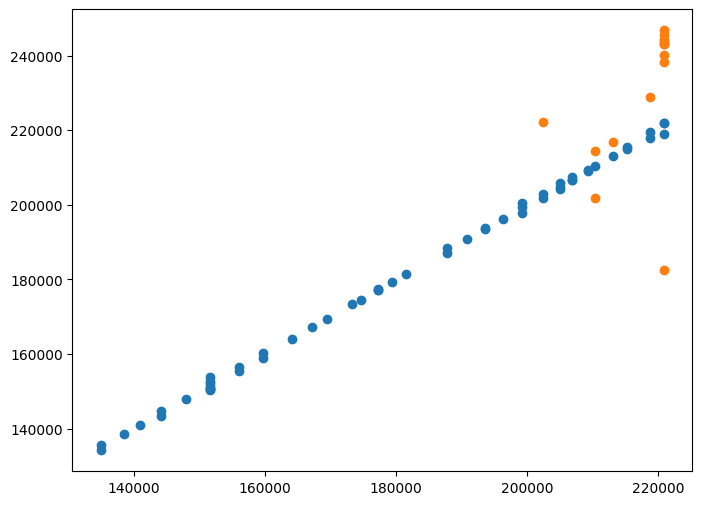

Error Cuadrático Medio Datos de Entrenamiento: 495152.56488454406
Error Cuadrático Medio Datos de Prueba: 438469224.25695246


In [56]:
# Gráfico de los valores predichos vs los verdaderos(entrenamiento y validación)

from matplotlib import pyplot as plt

# Usando la profundidad 5

decision_tree_PIB = DecisionTreeRegressor(max_depth=5)  #Creando el árbol con la profundidad anteriormente seleccionada - 5
decision_tree_PIB.fit(X_train_full, y_train_full) #Entrenando el árbol

# Predicción de entrenamiento y test
train_val_prediction = decision_tree_PIB.predict(X_train_full)
test_prediction = decision_tree_PIB.predict(X_test)

# Gráfico de las predicciones vs los verdaderos(lo ideal sería una recta y=x)
plt.figure(figsize=(8, 6))
plt.scatter(train_val_prediction, y_train_full, label='train')  # Azul, indican la predicción vs el verdadero valor, pero del entrenamiento
plt.scatter(test_prediction, y_test, label='test')  # Naranja, , indican la predicción vs el verdadero valor, pero del test
plt.show()
print("Error Cuadrático Medio Datos de Entrenamiento:",sklearn.metrics.mean_squared_error( train_val_prediction, y_train_full))

print("Error Cuadrático Medio Datos de Prueba:",sklearn.metrics.mean_squared_error(test_prediction, y_test))

72
72
72


,observado,Predicción
2006-01-01,134234.013588,134970.785751
2006-04-01,135707.557915,134970.785751
2006-07-01,138463.566525,138463.566525
2006-10-01,141029.861972,141029.861972
2007-01-01,143333.193576,144103.449963
2007-04-01,144873.706349,144103.449963
2007-07-01,147970.382545,147970.382545
2007-10-01,150279.717530,151624.518059
2008-01-01,150671.656974,151624.518059
2008-04-01,151427.832789,151624.518059


<Figure size 1000x600 with 0 Axes>

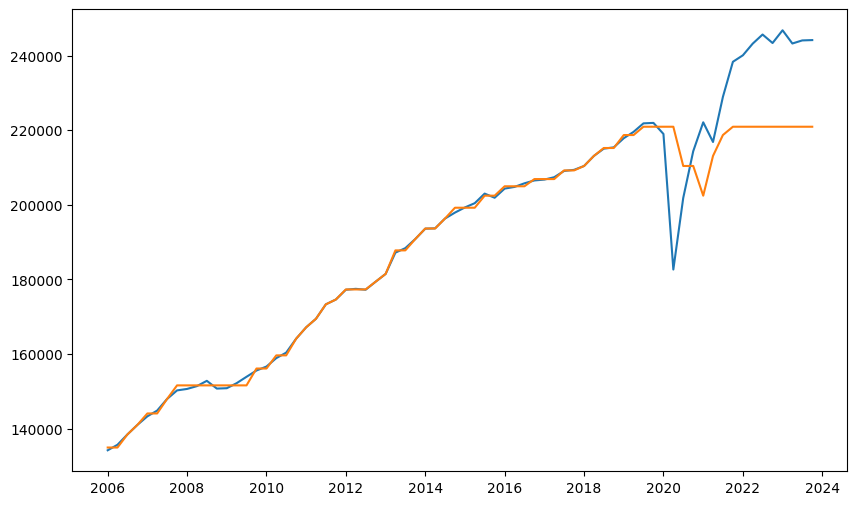

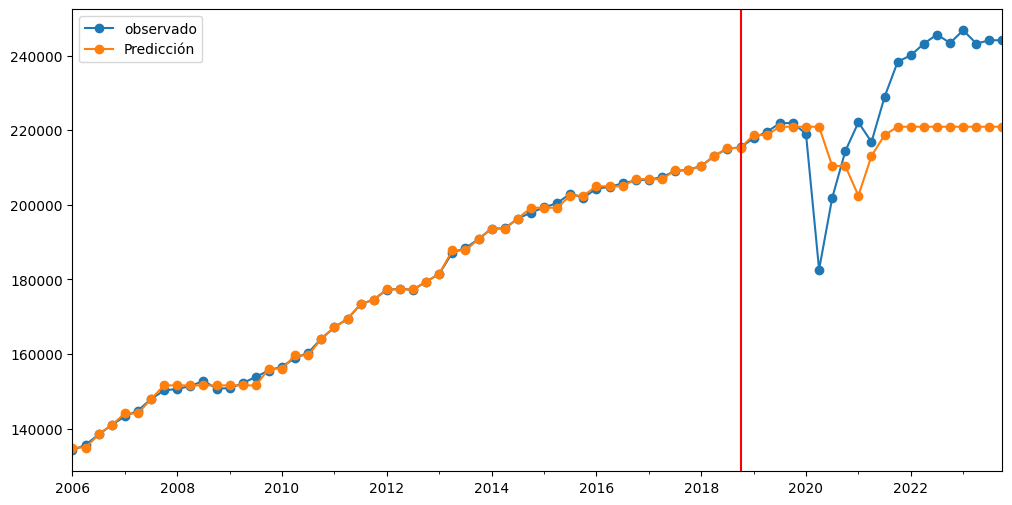

In [57]:
indicetrian_val_test=df1_qpro.index #Seleccionando los índices
print(indicetrian_val_test.size)
indicetrain_val=indicetrian_val_test[0:51]#Seleccionando los índices del entrenamiento y validación
indicetest=indicetrian_val_test[51:75]#Seleccionando los índices del test

targetjoint=np.concatenate((y_train_full,y_test))#Uniendo los verdaderos valores entrenamiento-validación con el test
predictionjoint=np.concatenate((train_val_prediction,test_prediction))#Uniendo las presicciones de entrenamiento-validación con test
print(targetjoint.size)
print(predictionjoint.size)
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=indicetrian_val_test)
ObsvsPred.head(10)#Recordemos que eliminamos las 4 primeras observaciones porque habían NA cuando organizamos los datos
#Gráfico simple de lo observado y lo predicho
plt.figure(figsize=(10, 6))
plt.plot(ObsvsPred)
ax = ObsvsPred.plot( marker="o", figsize=(12,6))
ax.axvline(x=indicetrian_val_test[51].date(),color='red')

In [58]:
InverArbol = pd.Series(pd.Series(np.concatenate([PIBTS[1::][:60].values,test_prediction]), index=pd.date_range('2005-01-01', periods=75, freq='QS',normalize=True)))#En este caso no hay que hacer nada, simplemente poner los datos originales y las 12 predicciones
fig = px.line(PIBTS, y="PIB", title="PIB en Colombia", template='plotly_dark')  # Se le puede quitar el modo oscuro si quiere
fig.add_trace(go.Scatter(x=InverArbol.index, y=InverArbol, mode='lines', name='Predicciones(árboles)'))
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1a", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

In [59]:
sklearn.metrics.mean_squared_error(InverArbol[-15:].values, PIBTS[:15][::-1].values)
((InverArbol[-15:].values-PIBTS[:15][::-1].values)**2).mean()#Manualmente

6141964443.543603

6141964443.543603

# Modelamiento utilizando Redes Neuronales
## Redes Neuronales Multicapa(MLP)

### Red Neuronal con una sola capa
Recordemos que los hiperparámetros de una red neuronal multicapa son la cantidad de capas, los nodos que tiene cada capa y la función de activación.
Para crear las capas se utiliza [], y se separan con comas. En este caso, hay una sola capa oculta, y una de salida (*keras.layers.Dense(1)*)
* *layers.Dense* - layers indica que voy a añadir una nueva capa, .Dense, que esa capa será Densa
* 64 son la cantidad de nodos que hay dentro de esa primera capa oculta.
* activation="linear" indica que la función de activación es lineal.
* *input_shape=X_train.shape[1:]* son la cantidad de columnas que tiene nuestro dataframe
* La capa de salida *keras.layers.Dense(1)* tiene un 1 debido a que nuestra variable respuesta es univariada

In [60]:
ModMLP1=keras.models.Sequential([keras.layers.Dense(64,activation="linear",input_shape=X_train.shape[1:]),keras.layers.Dense(1)])
ModMLP1.summary()

C:\Users\ander\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

Utilizaremos el error cuadrático medio como métrica y el optimizador adam.
Además, realizaremos 50 épocas, con un tamaño de lote de 10 (por defecto el tamaño de lote es 32), entonces tendré 51/10 lotes, 51 porque hay 51 datos de entrenamiento

In [61]:
ModMLP1.compile(loss="mean_squared_error",optimizer="adam")
historyMod1=ModMLP1.fit(X_train,y_train,batch_size=10,epochs=50,validation_data=(X_val,y_val)) 

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 29460781056.0000 - val_loss: 28156596224.0000
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15871988736.0000 - val_loss: 12540065792.0000
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6844090368.0000 - val_loss: 3746305280.0000
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1822810624.0000 - val_loss: 360576352.0000
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 136674048.0000 - val_loss: 138401904.0000
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 164626160.0000 - val_loss: 807810624.0000
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 540083712.0000 - val_loss: 1042369216.0000
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 616151488.0000 - val_loss: 714216320.0000
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 333534240.0000 - val_loss: 285294368.0000
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 127806352.0000 - val_loss: 43430592.0000


#### Comportamiento de la pérdida cuadrática en este conjunto de entrenamiento y validación

(50, 4)

<Axes: >

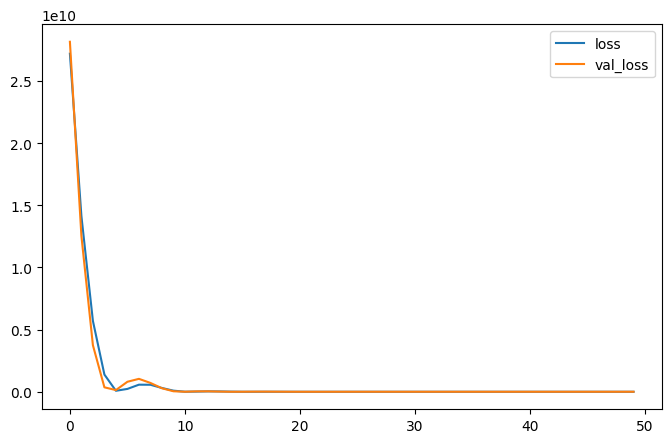

In [62]:
X_train.shape
pd.DataFrame(historyMod1.history).plot(figsize=(8,5))

In [63]:
mse_test1=ModMLP1.evaluate(X_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 157490960.0000


In [64]:
ypred1=ModMLP1.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


#### Gráfico de predicción y valores reales

<Figure size 600x600 with 0 Axes>

Text(0.5, 1.0, 'Real vs Predicción')

Text(0, 0.5, 'PIB')

Text(0.5, 0, 'índice')

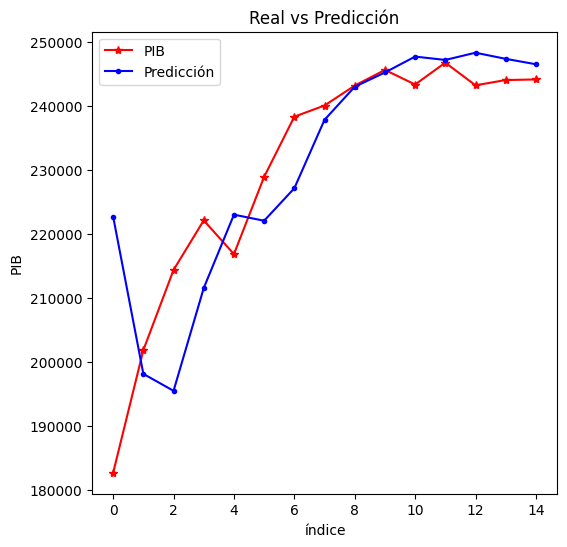

In [65]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_test.size), y_test, linestyle='-', marker='*', color='r')
plt.plot(range(ypred1.size), ypred1, linestyle='-', marker='.', color='b') 
plt.legend(['PIB','Predicción'], loc=2)
plt.title('Real vs Predicción')
plt.ylabel('PIB')
plt.xlabel('índice')

### Red neuronal con más capas
La anterior red neuronal contó con una sola capa oculta, la siguiente red contará con tres capas ocultas, de 64, 32, y 16 nodos respectivamente.
Utilizaremos la función de activación relu, así como un tamaño de lote igual a 10 y 50 épocas.

In [66]:
input_layer = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(64,activation="relu")(input_layer)
hidden2 = keras.layers.Dense(32,activation="relu")(hidden1)
hidden3 = keras.layers.Dense(16,activation="relu")(hidden2)
output_layer = keras.layers.Dense(1, activation='linear')(hidden3)

In [67]:
ModMLP2=keras.Model(inputs=[input_layer],outputs=[output_layer])
ModMLP2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
print("Input shape:", X_train.shape)
print("Target shape:", y_train.shape)

Input shape: (50, 4)
Target shape: (50,)


In [69]:
ModMLP2.compile(loss="mean_squared_error",optimizer="adam")
historyMod2=ModMLP2.fit(X_train,y_train,epochs=50,batch_size=10,validation_data=(X_val,y_val))

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - loss: 43572781056.0000 - val_loss: 57909706752.0000
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 37214605312.0000 - val_loss: 48204750848.0000
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 29451845632.0000 - val_loss: 44124340224.0000
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 28859947008.0000 - val_loss: 41330364416.0000
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 26790021120.0000 - val_loss: 39094337536.0000
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26228164608.0000 - val_loss: 36858769408.0000
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 23943915520.0000 - val_loss: 34071506944.0000
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 22831568896.0000 - val_loss: 31151687680.0000
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 19776450560.0000 - val_loss: 27973175296.0000
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 16976598016.0

<Axes: >

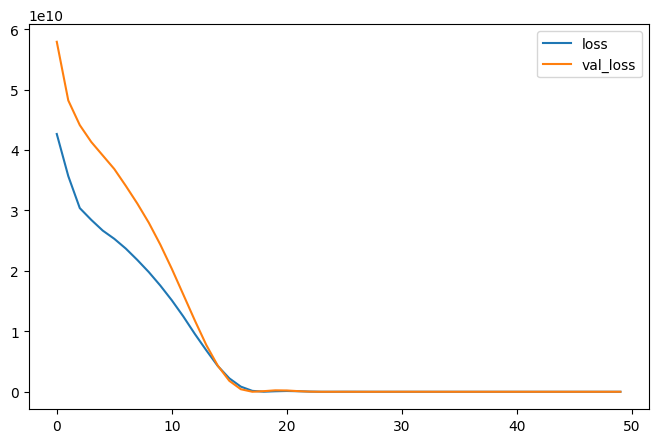

In [70]:
pd.DataFrame(historyMod2.history).plot(figsize=(8,5))

In [71]:
mse_test2=ModMLP2.evaluate(X_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 197555200.0000


In [72]:
100*(1-mse_test2/mse_test1)

-25.43907282043363

In [73]:
ypred2=ModMLP2.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


<Figure size 600x600 with 0 Axes>

Text(0.5, 1.0, 'Real vs Predicción')

Text(0, 0.5, 'PIB')

Text(0.5, 0, 'índice')

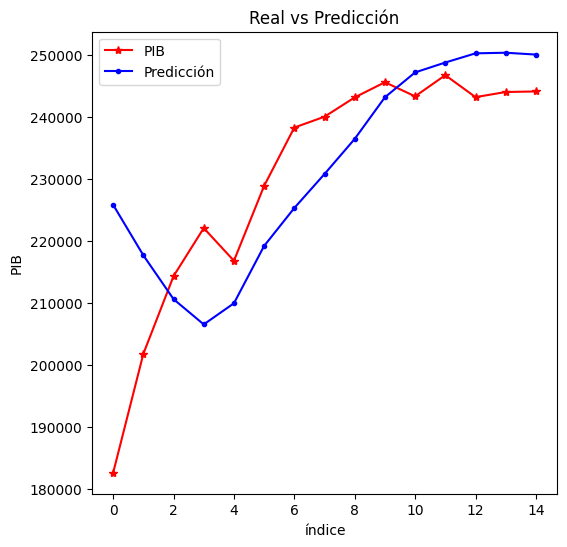

In [74]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_test.size), y_test, linestyle='-', marker='*', color='r')
plt.plot(range(ypred2.size), ypred2, linestyle='-', marker='.', color='b') 
plt.legend(['PIB','Predicción'], loc=2)
plt.title('Real vs Predicción')
plt.ylabel('PIB')
plt.xlabel('índice')

### Búsqueda de los hiperparámetros

In [75]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=64, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=64, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2,step=0.003)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"]
    )
    return model


build_model(kt.HyperParameters())

<Sequential name=sequential_1, built=False>

In [76]:
tuner_GridSearch_mlp = kt.GridSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=None,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

In [77]:
tuner_GridSearch_mlp.search_space_summary()

Search space summary
Default search space size: 6
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': 0.003, 'sampling': 'linear'}


In [78]:
stop_early=keras.callbacks.EarlyStopping(monitor="val_loss",patience=2)

In [79]:
tuner_GridSearch_mlp.search(X_train,y_train, epochs=20,batch_size=10, validation_data=(X_val,y_val),callbacks=[stop_early])

Trial 240 Complete [00h 00m 07s]
val_loss: 47792795648.0

Best val_loss So Far: 3869909.25
Total elapsed time: 00h 24m 05s


In [80]:
# Get the top 2 models.
models_mlp = tuner_GridSearch_mlp.get_best_models(num_models=2)
best_model_mlp = models_mlp[0]

C:\Users\ander\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 

C:\Users\ander\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 



#### Los mejores 10 modelos

In [81]:
tuner_GridSearch_mlp.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0038 summary
Hyperparameters:
num_units: 32
activation: relu
num_layers: 2
units_0: 64
dropout: False
lr: 0.010000000000000002
units_1: 32
Score: 3869909.25

Trial 0011 summary
Hyperparameters:
num_units: 32
activation: relu
num_layers: 1
units_0: 64
dropout: False
lr: 0.010000000000000002
Score: 3886178.25

Trial 0118 summary
Hyperparameters:
num_units: 64
activation: relu
num_layers: 1
units_0: 32
dropout: False
lr: 0.010000000000000002
units_1: 32
Score: 4079434.75

Trial 0019 summary
Hyperparameters:
num_units: 32
activation: relu
num_layers: 2
units_0: 32
dropout: False
lr: 0.004
units_1: 64
Score: 4094505.5

Trial 0151 summary
Hyperparameters:
num_units: 64
activation: relu
num_layers: 2
units_0: 32
dropout: False
lr: 0.010000000000000002
units_1: 64
Score: 4100738.75

Trial 0161 summary
Hyperparameters:
num_units: 64
activation: relu
num_layers: 2
units_0: 64

### Modelo final
Finalmente se entrenará el mejor modelo con los datos de entrenamiento y validación.

In [82]:
callback=keras.callbacks.EarlyStopping(monitor="loss",patience=5)
best_hps_mlp = tuner_GridSearch_mlp.get_best_hyperparameters(2)
model_mlp = build_model(best_hps_mlp[0])
# Fit with the entire dataset.
model_mlp.fit(X_train_full,y_train_full, epochs=50,batch_size=10,callbacks=[callback])

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 14021265408.0000 - mean_squared_error: 14021265408.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1276192256.0000 - mean_squared_error: 1276192256.0000 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 745523648.0000 - mean_squared_error: 745523648.0000   
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 407053344.0000 - mean_squared_error: 407053344.0000 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 187954144.0000 - mean_squared_error: 187954144.0000 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57610004.0000 - mean_squared_error: 57610004.0000
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 38794360.0000 - mean_squared_error: 38794360.0000
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29561374.0000 - mean_squared_error: 29561374.0000 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30036126.0000 - mean_squared_error: 30036126.0000 
Epoch 10/50
6/6 ━━━━

In [83]:
model_mlp.layers[0].get_weights()[0]

array([[ 0.22261511,  0.24818696,  0.36292803, -0.13793626,  0.11709474,
        -0.10489483, -0.07967156,  0.43967515,  0.10440278, -0.31222638,
        -0.35715845, -0.04089782,  0.09080078, -0.07718205,  0.30103397,
         0.05780968,  0.23008627, -0.15484571,  0.22980213, -0.11800647,
        -0.3211011 ,  0.1004588 ,  0.2434856 ,  0.31568915, -0.38762605,
        -0.33846802,  0.36599317,  0.2670524 , -0.03536892, -0.07811353,
        -0.04563711, -0.4213634 ],
       [ 0.3022171 ,  0.03769082,  0.18073463, -0.23240522,  0.2614517 ,
         0.20560248, -0.17802152,  0.14180474, -0.13921893,  0.26325482,
        -0.23885264,  0.2878684 ,  0.05250958,  0.03424171,  0.22860081,
         0.17772716,  0.39493954, -0.27648848,  0.34749535, -0.34880704,
        -0.20987104,  0.20741159, -0.05727681,  0.00786439, -0.09459734,
         0.29183728,  0.39830408, -0.39650777, -0.36586142, -0.3041024 ,
         0.30629107, -0.31659335],
       [-0.05894335,  0.31222922,  0.2188164 ,  0.0262

In [84]:
print(model_mlp.layers[0].bias.numpy())

[-0.02011402  0.03749409  0.03602411  0.          0.03155727  0.02414297
  0.          0.04393939  0.          0.         -0.06005457 -0.07475702
 -0.02278678  0.          0.05180112  0.          0.00668759  0.
 -0.04892251  0.          0.          0.         -0.05813449  0.
  0.          0.          0.00674888  0.          0.         -0.025539
  0.04854501 -0.0312551 ]


In [85]:
X_test.shape

(15, 4)

In [86]:
prediction_test=model_mlp.predict( X_test, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


In [87]:
y_test=y_test.reshape((y_test.shape[0], 1))

In [88]:
errors_squared=keras.metrics.MeanSquaredError()
errors_squared.update_state(y_test, prediction_test)
print("ECM:",errors_squared.result().numpy())

#errors_squared=keras.metrics.mean_squared_error(y_test, prediction_test).numpy()
#print("RECM:",errors_squared.mean()**0.5)

ECM: 227726100.0


Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

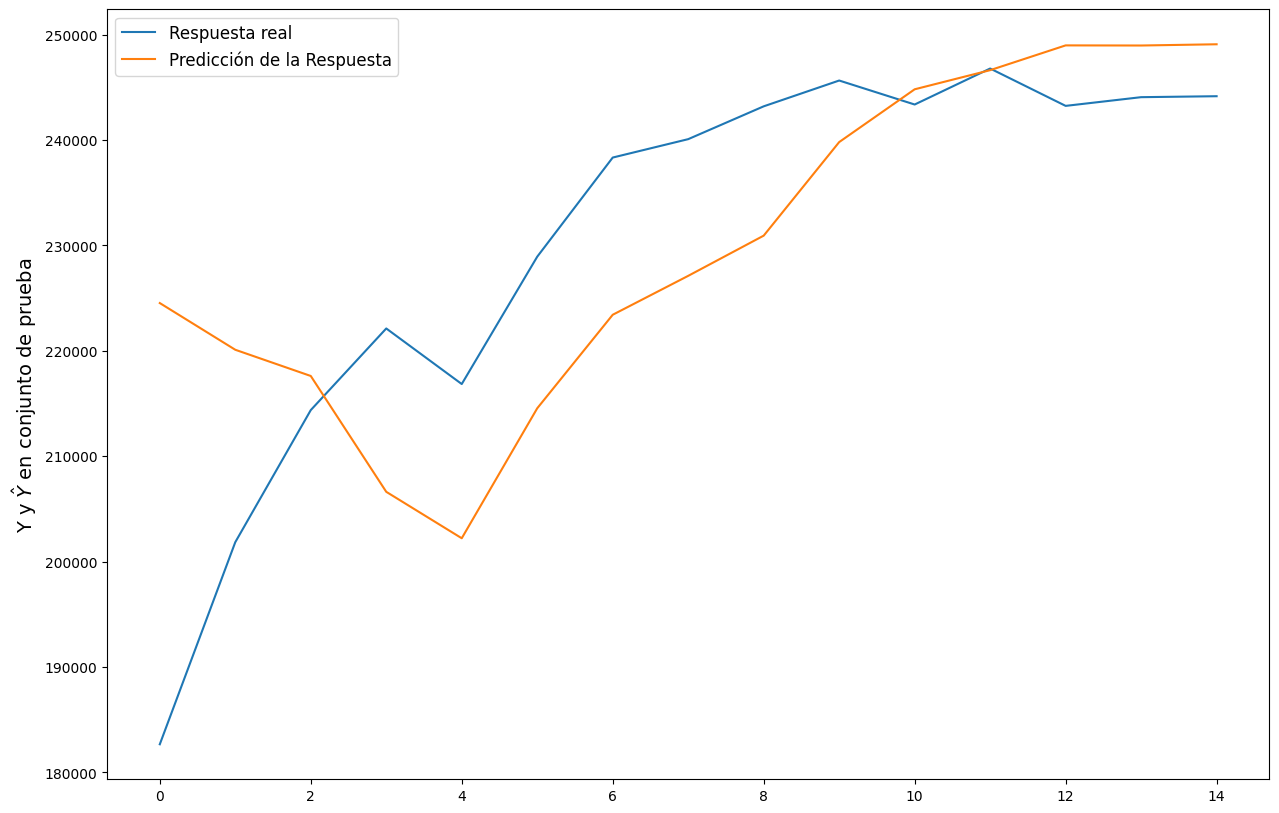

In [89]:
plt.plot(y_test)
plt.plot(prediction_test)
plt.legend(['Respuesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

Text(0, 0.5, '$\\hat{e}$ en conjunto de prueba')

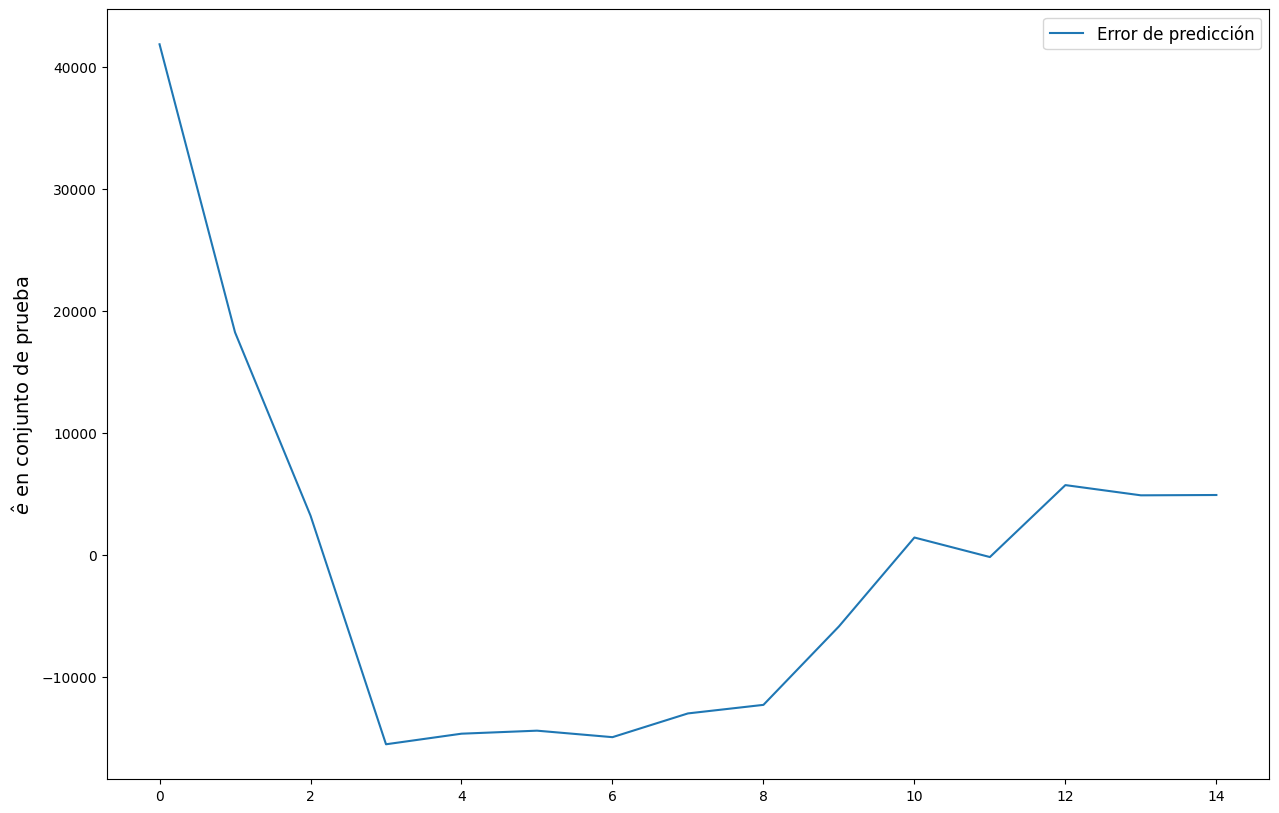

In [90]:
#Gráfico de errores
plt.plot(prediction_test-y_test)
plt.legend(['Error de predicción'],loc="best", fontsize=12)
plt.ylabel('$\hat{e}$ en conjunto de prueba', fontsize=14)